In [1]:
from cp import data, visualize, validate, exchangeable, logger as _logger
import matplotlib.pyplot as plt
import numpy as np
SEED: int = 123
np.random.seed(SEED)
MISCOVERAGE: float = 0.10 # MISCOVERAGE = alpha # CONFIDENCE = 1-alpha 
logger = _logger.Logger()

# Exchangeable data

## Toy problem

In [2]:
N_SAMPLES: int = 5000
NOISE: float = 0.1
toy_problem = data.ToyProblem(noise=NOISE, N=N_SAMPLES)

### First dataset
$$ Y = \sin{2X} + \epsilon \left( U - \frac{1}{2} \right)$$
Being $X \in [0, 2\pi)$, $U\in [0, 1]$ a random variable following a uniform distribution and $\epsilon$ a small quantity which tunes the noise level.
Namely, we have:
- Single Variable Input
- Homoscedastic Uncertainty
- Low Uncertainty
- Trigonometric Relationships between Input and Output

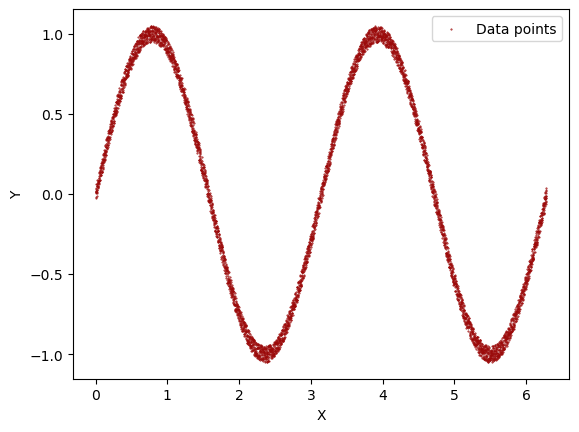

In [3]:
X, y = (toy_problem.first_data)
visualize.data({'X': X, 'y': y});
X_train, X_test, y_train, y_test = data.split(X, y)

We will compare three methods of quantifying the uncertainty: split (`SCP`), Jackknife+ after Bootstrap (`J+aB`), CQR (`CQR`).

In [4]:
from mapie.subsample import Subsample

strategies_names = {
    'SCP': 'Split Conformal Prediction',
    'CV+': 'Cross Validation +',
    'J+aB': 'Jackknife+ after Bootstrapping',
    # 'CQR': 'Conformalized Quantile Regression'
}
strategies_params = {
    'SCP': {'method': 'base', 'cv': "split"},
    'CV+': {'method': "plus", 'cv': 10},
    'J+aB': {'method': "plus", 'cv': Subsample(n_resamplings=50)},
    # 'CQR': {'method': "quantile", 'cv': "split", 'alpha': MISCOVERAGE}
}

Let us perform a polynomial fit and, then, assess its uncertainty.

In [5]:
DEGREE: int = 10

from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

params = {
    'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 
    'miscoverage': MISCOVERAGE, 'seed': SEED
}
base_estimators = {
    'SCP': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'CV+': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'J+aB': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    # 'CQR': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', QuantileRegressor(solver="highs"))])
} 

y_pred, int_pred, mapie_estimator = exchangeable.train_strategies(
    params, base_estimators, strategies_params, strategies_names)

05/10/2024 10:31:11 AM     INFO >> Training Split Conformal Prediction
05/10/2024 10:31:11 AM     INFO >> Training Cross Validation +
05/10/2024 10:31:11 AM     INFO >> Training Jackknife+ after Bootstrapping


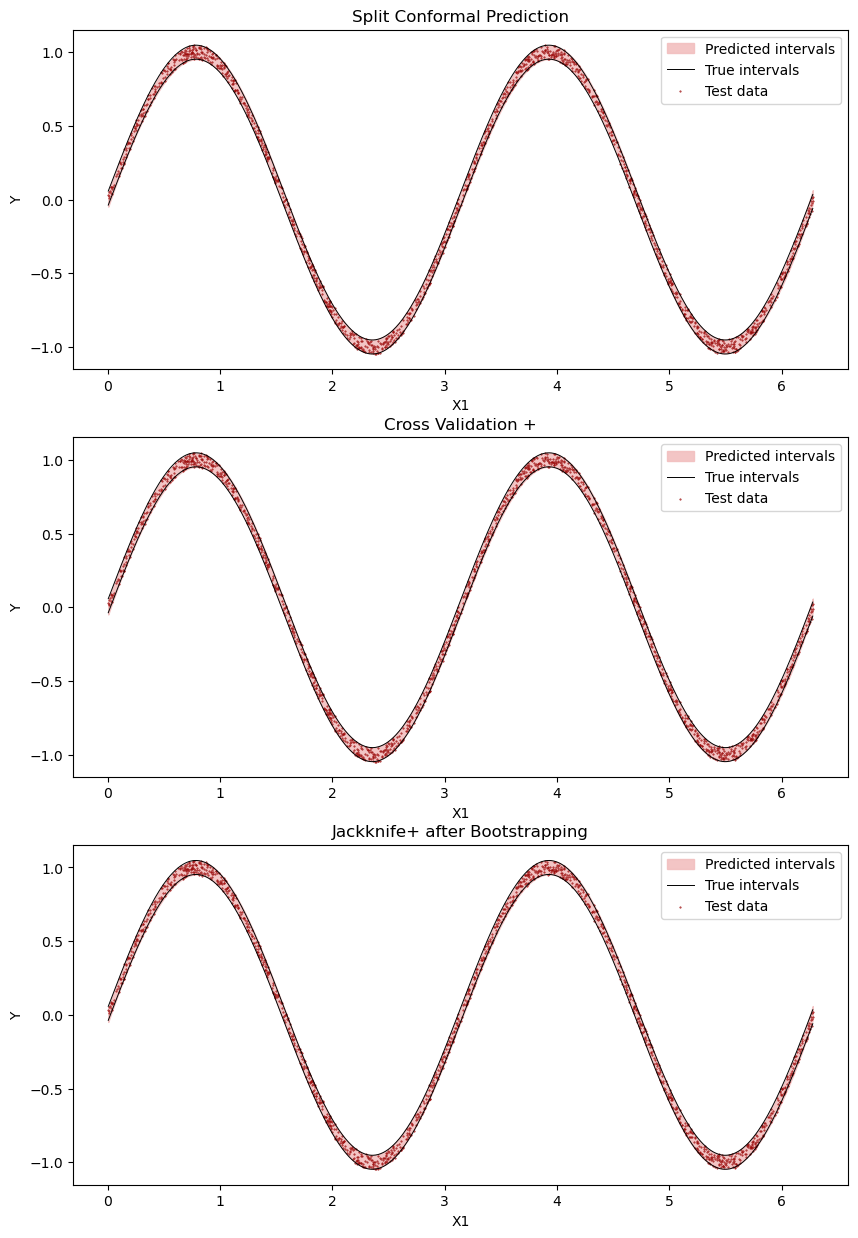

In [6]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

# True intervals
_y_true_up, _y_true_low = (toy_problem.first_intervals(X_test, MISCOVERAGE))

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.data(
        {'X': X_test, 'y': y_test},
        bounds={
            'X': X_test.ravel(), 
            'y_low': _y_pred_low, 
           'y_up': _y_pred_up},
        intervals={
            'X': X_test.ravel(), 
            'y_low': _y_true_low, 
            'y_up': _y_true_up},
        xlabel='X1',
        title=strategies_names[_strat], 
        points_label='Test data',
        ax=axs[_i]
        )

Let us assess some metrics and plot different validation figures:

- **Average goodness**

05/10/2024 10:33:08 AM     INFO >> Validating SCP coverage
05/10/2024 10:33:08 AM     INFO >> Validating CV+ coverage
05/10/2024 10:33:08 AM     INFO >> Validating J+aB coverage
05/10/2024 10:33:08 AM     INFO >> Validating SCP width
05/10/2024 10:33:08 AM     INFO >> Validating CV+ width
05/10/2024 10:33:08 AM     INFO >> Validating J+aB width
05/10/2024 10:33:08 AM     INFO >> Validating SCP RMSE
05/10/2024 10:33:08 AM     INFO >> Validating CV+ RMSE


05/10/2024 10:33:08 AM     INFO >> Validating J+aB RMSE
05/10/2024 10:33:08 AM     INFO >> Validating SCP CWC
05/10/2024 10:33:08 AM     INFO >> Validating CV+ CWC
05/10/2024 10:33:08 AM     INFO >> Validating J+aB CWC


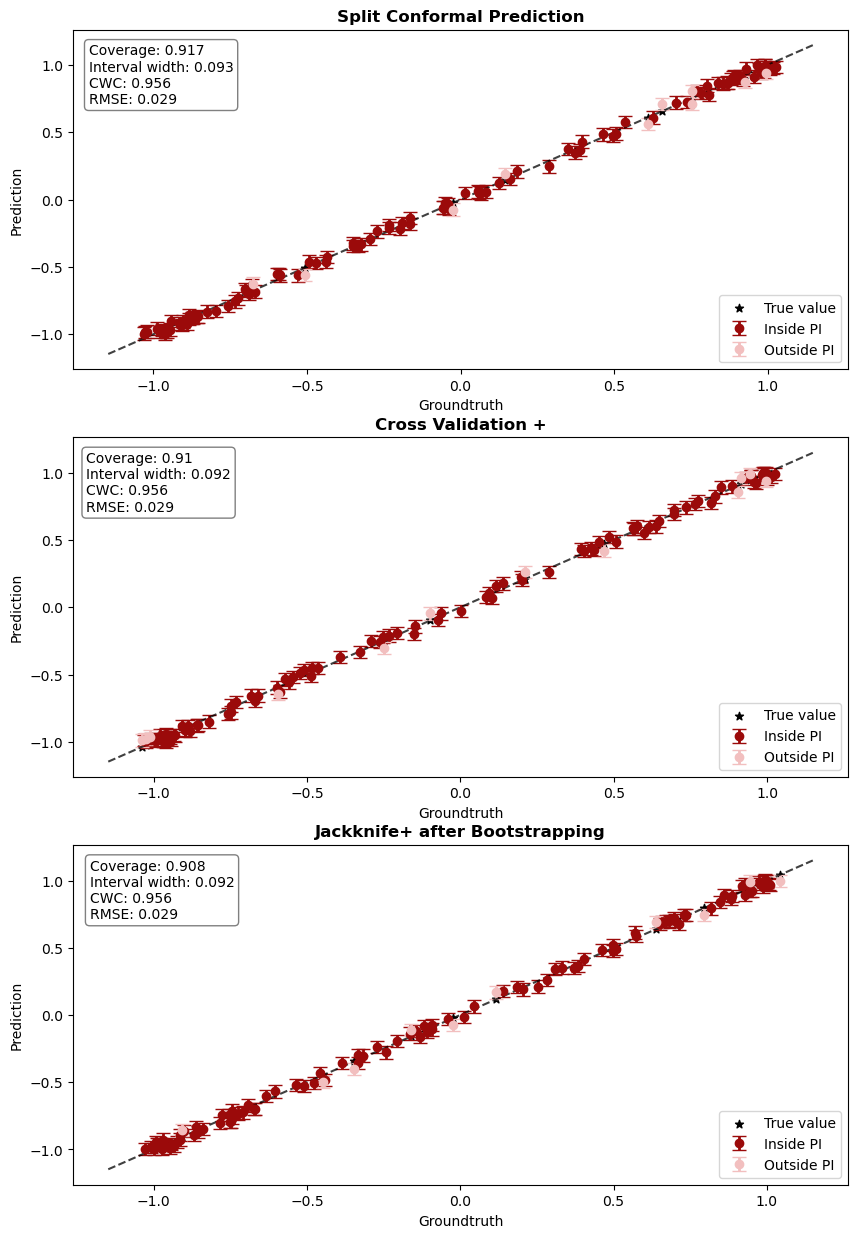

In [8]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE)

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.goodness(
        y_test, y_pred[_strat],
        _y_pred_low, 
        _y_pred_up,
        coverages[_strat],
        widths[_strat],
        rmse[_strat],
        cwc[_strat],
        ax=axs[_i],
        subsample=0.075,
        title=strategies_names[_strat], 
    )

For visualization purposes, note that just a 7.5% of the test data was shown. 

- Marginal vs. conditional coverage: **coverage vs. width**

### Second dataset
$$ Y = \sin{2X_1} + 5\epsilon \left(U - \frac{1}{2}\right) (1 - \sin{X_2})\cos{X_2} $$
Being $X_1,X_2 \in [0, 2\pi)$, $U\in [0, 1]$ a random variable following a uniform distribution and $\epsilon$ a small quantity which tunes the noise level.
Namely, we have:
- Two Variable Input
    - Note $X_1$ mainly determines the prediction, while $X_2$ determines the direction and magnitude of uncertainty.
- Heterocedastic Uncertainty
    - The variance of $Y$ depends on the $X_2$ feature space and it is not constant
- High Uncertainty
    - At most, five times bigger than before
- Trigonometric Relationships between Input and Output

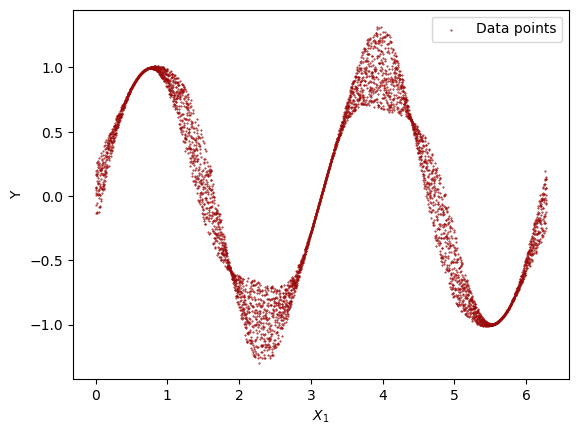

In [9]:
X, y = (toy_problem.second_data)
visualize.data({'X': X['X1'], 'y': y}, xlabel='$X_1$');
X_train, X_test, y_train, y_test = data.split(X, y)

In [10]:
DEGREE: int = 10

params = {
    'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 
    'miscoverage': MISCOVERAGE, 'seed': SEED
}
base_estimators = {
    'SCP': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'CV+': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    'J+aB': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', LinearRegression())]),
    # 'CQR': Pipeline([('poly', PolynomialFeatures(degree=DEGREE)), ('linear', QuantileRegressor(solver="highs"))])
} 

y_pred, int_pred, mapie_estimator = exchangeable.train_strategies(
    params, base_estimators, strategies_params, strategies_names)

05/10/2024 10:33:57 AM     INFO >> Training Split Conformal Prediction
05/10/2024 10:33:57 AM     INFO >> Training Cross Validation +
05/10/2024 10:33:58 AM     INFO >> Training Jackknife+ after Bootstrapping


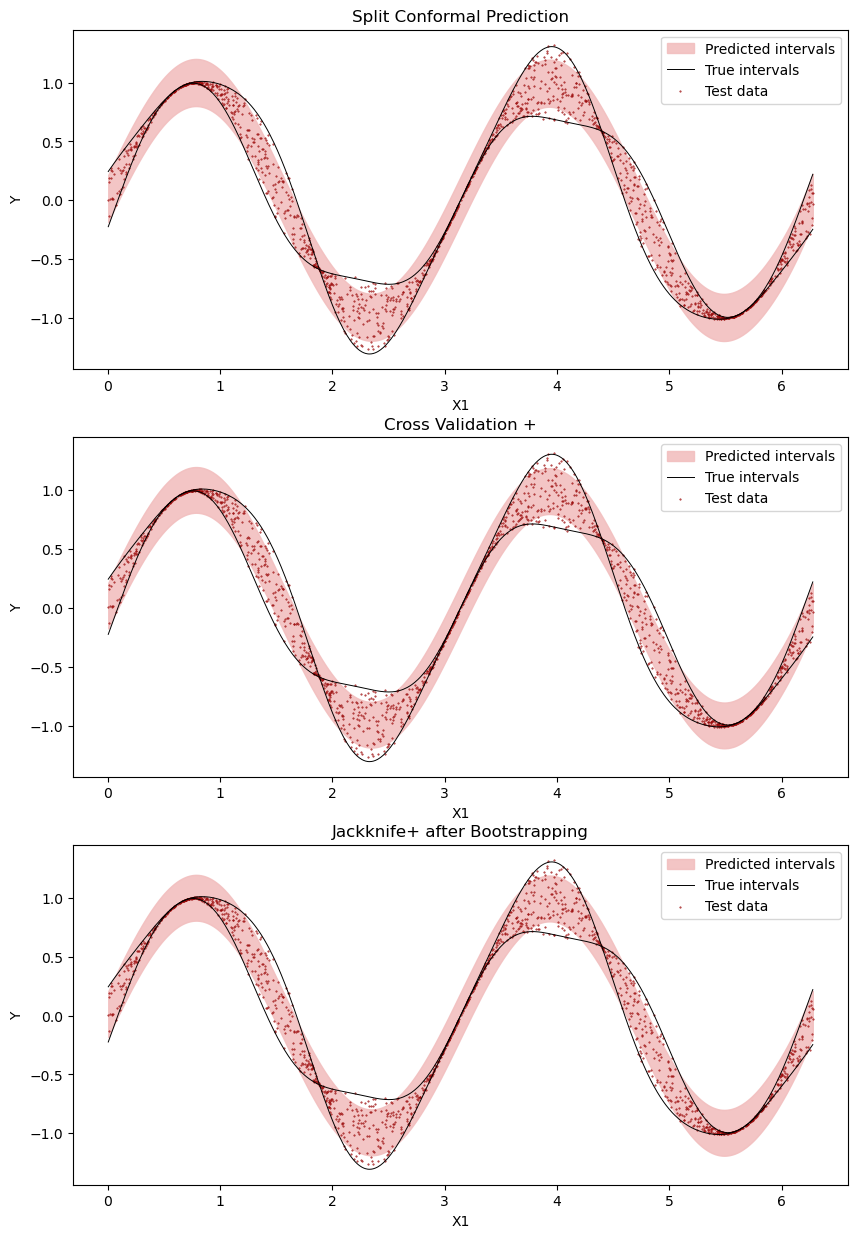

In [11]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

# True intervals
_y_true_up, _y_true_low = (toy_problem.second_intervals(X_test[:, 0], X_test[:, 1], MISCOVERAGE))

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.data(
        {'X': X_test[:, 0], 'y': y_test},
        bounds={
            'X': X_test[:, 0].ravel(), 
            'y_low': _y_pred_low, 
            'y_up': _y_pred_up},
        intervals={
            'X': X_test[:, 0].ravel(), 
            'y_low': _y_true_low, 
            'y_up': _y_true_up},
        xlabel='X1',
        title=strategies_names[_strat], 
        points_label='Test data',
        ax=axs[_i])

- **Average goodness**

05/10/2024 10:35:00 AM     INFO >> Validating SCP coverage
05/10/2024 10:35:00 AM     INFO >> Validating CV+ coverage
05/10/2024 10:35:00 AM     INFO >> Validating J+aB coverage
05/10/2024 10:35:00 AM     INFO >> Validating SCP width
05/10/2024 10:35:00 AM     INFO >> Validating CV+ width
05/10/2024 10:35:00 AM     INFO >> Validating J+aB width
05/10/2024 10:35:00 AM     INFO >> Validating SCP RMSE
05/10/2024 10:35:00 AM     INFO >> Validating CV+ RMSE
05/10/2024 10:35:00 AM     INFO >> Validating J+aB RMSE
05/10/2024 10:35:00 AM     INFO >> Validating SCP CWC
05/10/2024 10:35:00 AM     INFO >> Validating CV+ CWC
05/10/2024 10:35:00 AM     INFO >> Validating J+aB CWC


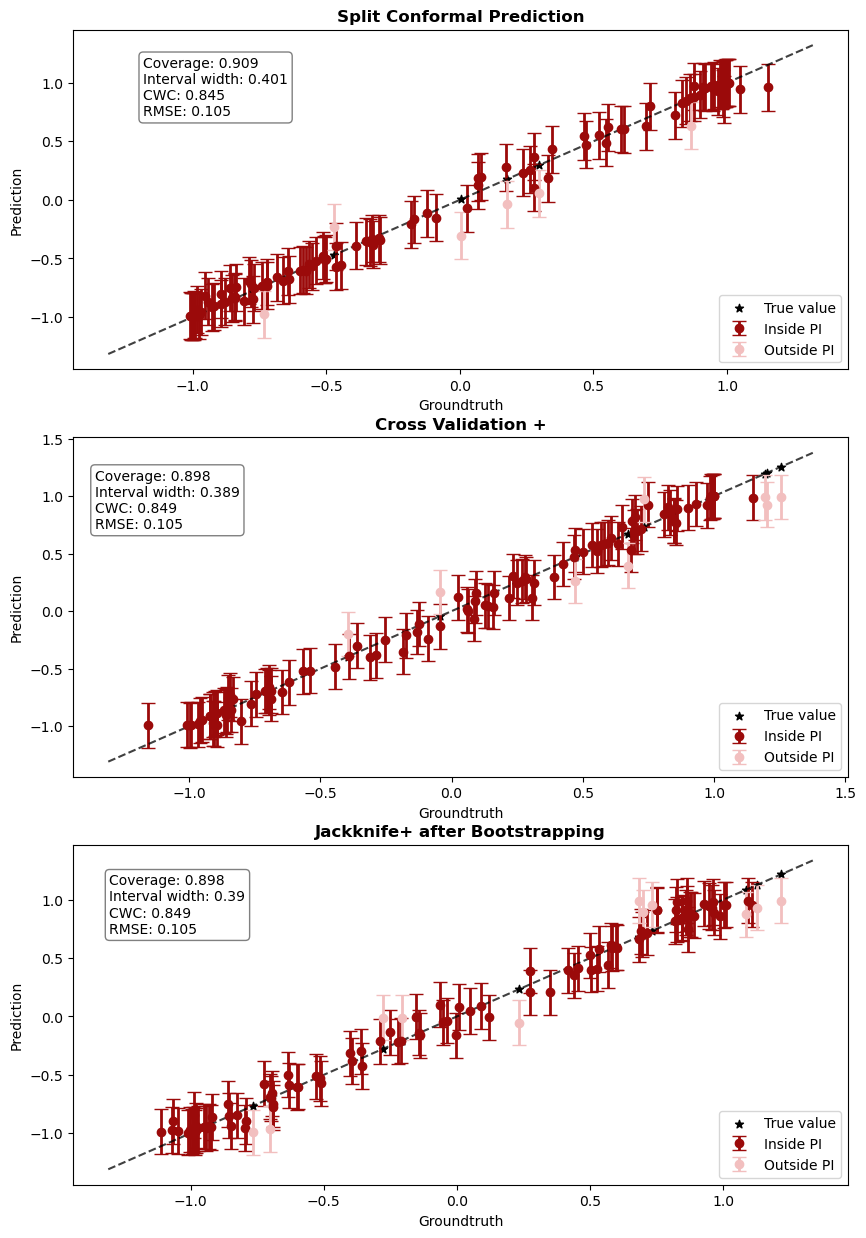

In [12]:
fig, axs = plt.subplots(nrows=len(base_estimators), figsize=(10, 15));

coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE)

for _i, _strat in enumerate(strategies_names.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.goodness(
        y_test, y_pred[_strat],
        _y_pred_low, 
        _y_pred_up,
        coverages[_strat],
        widths[_strat],
        rmse[_strat],
        cwc[_strat],
        ax=axs[_i],
        subsample=0.075,
        title=strategies_names[_strat], 
    )